In [1]:
import sys
sys.path.insert(0,'C:/Users/birnb/AppData/Local/Python/Lib/site-packages/getfem/getfem')
sys.path.insert(0,'C:/Users/birnb/Documents/GetFEM/getfem++_5.3+dfsg1.orig.tar/getfem-5.3/interface/tests/meshes')
import getfem as gf
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline
import pandas as pd

Problem Setup

In [55]:
# Define parameters
L_x = 1; L_y = 1; # length of boundaries
nx = 20; ny = 20; # number of elements

u_x = 1

T0 = 1100 # temperature in deg C
vfta = -4.55; vftb = 4901.9; vftc = 656.0; #For a typical basalt
kappa = 0.01 # thermal diffusivity
t_flux = -1

def mu_f(temp, vfta=-4.55, vftb=4901.9, vftc=656.0):
    return np.exp(vfta + vftb/(temp + 273 - vftc))
mu = mu_f(T0)

mu_exp = 'exp(' + str(vfta) + '+ ' + str(vftb) + '/(t + 273 - ' + str(vftc) + '))'
gf.asm_define_function('mu_f', 1, mu_exp)

temp = True;

In [56]:
mu_exp = 'exp(' + str(vfta) + '+ ' + str(vftb) + '/(t + 273 - ' + str(vftc) + '))'
mu_exp

'exp(-4.55+ 4901.9/(t + 273 - 656.0))'

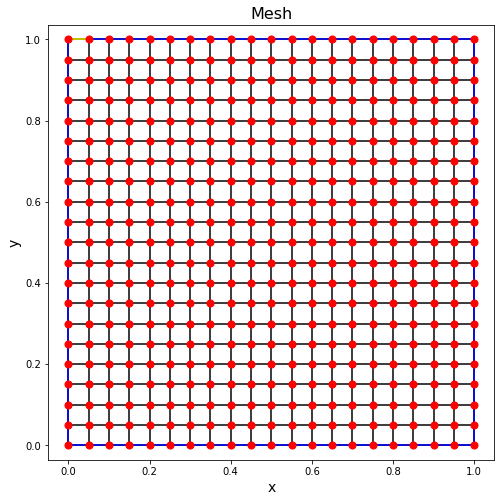

In [57]:
# Mesh generation for structured quad elements
mesh = gf.Mesh('cartesian', np.linspace(0,L_x,nx+1), np.linspace(0,L_y,ny+1))

fb_right = mesh.outer_faces_with_direction([ 1., 0.], 0.01) # outward vector in [x,y], tolerance angle theta (rad)
fb_left = mesh.outer_faces_with_direction([-1., 0.], 0.01)
fb_top = mesh.outer_faces_with_direction([0.,  1.], 0.01)
fb_bot = mesh.outer_faces_with_direction([0., -1.], 0.01)
fb_topleft = mesh.outer_faces_in_box([-0.01, L_y-L_y/(2*ny)], [L_x/nx*1.5, 1.01]) # top left

bounds = [fb_right, fb_left, fb_top, fb_bot, fb_topleft]
RIGHT_BOUND=1; LEFT_BOUND=2; TOP_BOUND=3; BOTTOM_BOUND=4; TOPLEFT_BOUND=5;

for i,bound in enumerate(bounds): 
    mesh.set_region(i+1, bound)

# export to vtk for visualization through python
#mesh.export_to_vtk('mesh.vtk')
# You can view the mesh for instance with
# mayavi2 -d mesh.vtk -f ExtractEdges -m Surface

# visualize mesh points
fig, ax = plt.subplots(figsize=(8,8))
[x,y] = mesh.pts() # get nodes
ax.scatter(x,y,50,'r',zorder=2) # plot nodes

# plot all mesh edges (no overlap)
for face in mesh.faces_from_cvid('merge').transpose():
        edge = mesh.pid_in_faces(CVFIDs=face)
        ax.plot(x[edge], y[edge],'k',zorder=0)
        
# plot edges on BCs
for i, bound in enumerate(bounds):
    for face in bound.transpose():
        edge = mesh.pid_in_faces(CVFIDs=face)
        ax.plot(x[edge], y[edge],'b',zorder=1,label='BC')
        if i==4:
            ax.plot(x[edge], y[edge],'y',linewidth=2,zorder=1,label='BC')
        
ax.axis('equal')
ax.set_xlabel('x',fontsize=14)
ax.set_ylabel('y',fontsize=14)
ax.set_title('Mesh',fontsize=16);

FEM approximations

In [58]:
# Define variable fields and approximations
# velocity
mfu = gf.MeshFem(mesh, 2) # vector field
mfu.set_classical_fem(2) # continuous piecewise linear
# pressure
mfp = gf.MeshFem(mesh, 1) # scalar field
mfp.set_classical_fem(1) # continuous piecewise linear

# temperature
if temp:
    mft = gf.MeshFem(mesh, 1) # scalar field
    mft.set_classical_fem(2) # continuous piecewise quadratic

mim = gf.MeshIm(mesh, 4)

Build weak form and apply BCs

In [64]:
# use model blocks to assemble problem - can alternatively be done manually
md=gf.Model('real'); # real vs complex system
md.add_fem_variable('u', mfu)
md.add_fem_variable('p', mfp)

# add coefficients
md.add_initialized_data('mu', [mu])
md.add_initialized_data('lambda', [0])

if temp: 
    md.add_fem_variable('t',mft)
    md.add_initialized_data('vfta', [vfta])
    md.add_initialized_data('vftb', [vftb])
    md.add_initialized_data('vftc', [vftc])
    md.add_initialized_data('kappa', [kappa])
    md.add_initialized_data('t_flux', [kappa])
    

# add via pre-defined model brick
#md.add_isotropic_linearized_elasticity_brick(mim, 'u', 'clambdastar', 'cmu')
# equivalently md.add_linear_term(mim, “lambda*(Div_u*Div_Test_u) + mu*((Grad_u + Grad_u’):Grad_Test_u)”
# See https://www.getfem.org/userdoc/gasm_high.html#ud-gasm-high
md.add_nonlinear_term(mim, "mu_f(t)*((Grad_u + Grad_u'):Grad_Test_u)")
#md.add_isotropic_linearized_elasticity_brick(mim, 'u', 'lambda', 'mu')
#md.add_linear_term(mim, “mu*((Grad_u + Grad_u’):Grad_Test_u)”)
md.add_linear_incompressibility_brick(mim, 'u', 'p')
#md.add

if temp: 
    md.add_nonlinear_term(mim, "kappa*(Grad_t.Grad_Test_t) + (u.Grad_t)*Test_t")

# Apply BCs
D = mfp.basic_dof_nodes()
ones = np.ones(D.shape[1])

D_t = mft.basic_dof_nodes()
ones_t = np.ones(D_t.shape[1])

md.add_initialized_fem_data('rightdata', mfp, [0*ones,0*ones])
md.add_initialized_fem_data('leftdata', mfp, [0*ones,0*ones])
md.add_initialized_fem_data('topdata', mfp, [u_x*ones,0*ones])
md.add_initialized_fem_data('botdata', mfp, [0*ones,0*ones])

md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, RIGHT_BOUND, dataname='rightdata')
md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, LEFT_BOUND, dataname='leftdata')
md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, TOP_BOUND, dataname='topdata')
md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, BOTTOM_BOUND, dataname='botdata')

if temp:
    md.add_initialized_fem_data('leftdata_t', mft, [T0*ones_t])
    md.add_Dirichlet_condition_with_multipliers(mim, 't', 0, LEFT_BOUND, dataname='leftdata_t');
    
    md.add_initialized_fem_data('topdata_t', mft, [t_flux*ones_t,t_flux*ones_t])
    md.add_initialized_fem_data('insulate_t', mft, [0*ones_t,0*ones_t])
    md.add_normal_source_term_brick(mim, 't', "insulate_t", LEFT_BOUND);
    md.add_normal_source_term_brick(mim, 't', "insulate_t", RIGHT_BOUND);
    #md.add_normal_source_term_brick(mim, 't', "insulate_t", BOTTOM_BOUND);
    md.add_normal_source_term_brick(mim, 't', "topdata_t", TOP_BOUND);

Solve

In [65]:
# solve all in one
md.solve('max_res', 1E-9, 'max_iter', 100, 'noisy'); # Newton iteration for nonlinearity

Visualize results

C:\Users\birnb\anaconda3\envs\Getfem\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\birnb\anaconda3\envs\Getfem\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\birnb\anaconda3\envs\Getfem\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify th

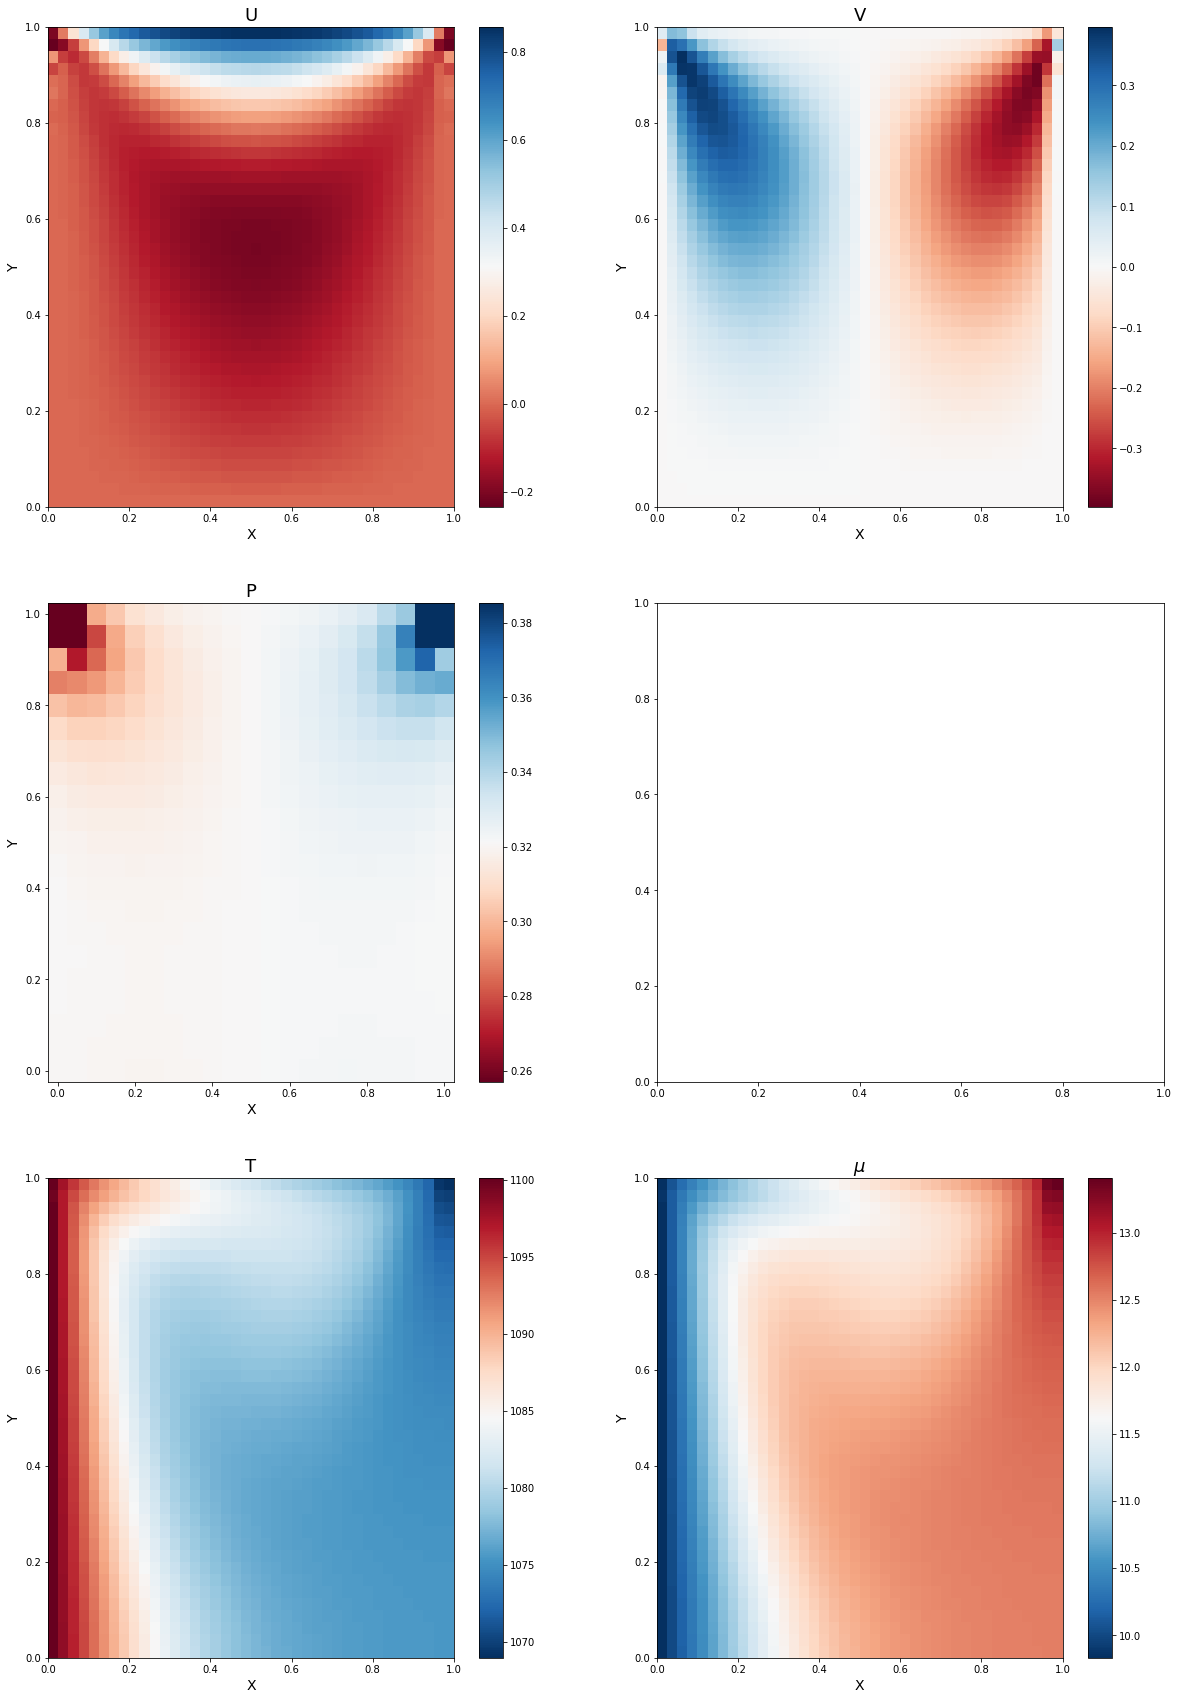

In [72]:
# Velocity
u = md.variable('u')
P = md.variable('p')
T = md.variable('t')

[x,y] = mfu.basic_dof_nodes()
x = x.reshape(int(len(x)/2),2)
y = y.reshape(int(len(y)/2),2)
u = u.reshape(int(len(u)/2),2)

dat = pd.DataFrame(data={'x':x[:,0],'y':y[:,0],'ux':u[:,0],'uy':u[:,1]})
dat_sort = dat.sort_values(by=['y','x'], ascending=True,)
ux = dat_sort.ux.values.reshape(int(np.sqrt(u.shape[0])),int(np.sqrt(u.shape[0])))
uy = dat_sort.uy.values.reshape(int(np.sqrt(u.shape[0])),int(np.sqrt(u.shape[0])))

fig, ax = plt.subplots(figsize=(20,30),ncols=2,nrows=3)
c1 = ax[0,0].pcolormesh(np.unique(x),np.unique(y),ux,cmap='RdBu',shading='auto')
plt.colorbar(c1,ax=ax[0,0])
c2 = ax[0,1].pcolormesh(np.unique(x),np.unique(y),uy,cmap='RdBu',shading='auto')
plt.colorbar(c2,ax=ax[0,1])

# Pressure
[xp,yp] = mfp.basic_dof_nodes()

datp = pd.DataFrame(data={'x':xp,'y':yp,'p':P})
datp_sort = datp.sort_values(by=['y','x'], ascending=True,)
P = datp_sort.p.values.reshape(int(np.sqrt(P.shape[0])),int(np.sqrt(P.shape[0])))

c1 = ax[1,0].pcolormesh(np.unique(xp),np.unique(yp),P,cmap='RdBu',shading='auto',vmin=0.8*np.mean(P),vmax=1.2*np.mean(P))
plt.colorbar(c1,ax=ax[1,0])

# Temperature
[xt,yt] = mft.basic_dof_nodes()

datt = pd.DataFrame(data={'x':xt,'y':yt,'t':T})
datt_sort = datt.sort_values(by=['y','x'], ascending=True,)
T = datt_sort.t.values.reshape(int(np.sqrt(T.shape[0])),int(np.sqrt(T.shape[0])))

c1 = ax[2,0].pcolormesh(np.unique(xt),np.unique(yt),T,cmap='RdBu_r',shading='auto')
plt.colorbar(c1,ax=ax[2,0])

c1 = ax[2,1].pcolormesh(np.unique(xt),np.unique(yt),mu_f(T),cmap='RdBu_r',shading='auto')
plt.colorbar(c1,ax=ax[2,1])

for i, axi in enumerate(ax.reshape(6,1)):
    if not i == 3:
        axi[0].set_xlabel('X',fontsize=14)
        axi[0].set_ylabel('Y',fontsize=14)
ax[0,0].set_title('U',fontsize=18)
ax[0,1].set_title('V',fontsize=18)
ax[1,0].set_title('P',fontsize=18)
ax[2,0].set_title('T',fontsize=18)
ax[2,1].set_title('$\mu$',fontsize=18);